In [10]:
# general
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# torch
import torch
from torch import nn, optim
import torch.nn.functional as F

# scikit
from sklearn.model_selection import train_test_split

In [3]:
# plots config
%matplotlib inline
%config InlineBackend.figure_format="retina"

palette = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(palette=palette))

# seeding
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv("./data/weather-australian/weatherAUS.csv")
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [5]:
# cols to use
cols = ["Rainfall", "Humidity3pm", "Pressure9am", "RainToday", "RainTomorrow"]
df = df[cols]
df

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No
...,...,...,...,...,...
145455,0.0,24.0,1024.6,No,No
145456,0.0,21.0,1023.5,No,No
145457,0.0,24.0,1021.0,No,No
145458,0.0,24.0,1019.4,No,No


In [6]:
# convert everything to numbers
df.RainToday.replace({"No": 0, "Yes": 1}, inplace=True)
df.RainTomorrow.replace({"No": 0, "Yes": 1}, inplace=True)
df

/tmp/ipykernel_14462/2482134236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.RainToday.replace({"No": 0, "Yes": 1}, inplace=True)
/tmp/ipykernel_14462/2482134236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.RainTomorrow.replace({"No": 0, "Yes": 1}, inplace=True)


,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0.0
1,0.0,25.0,1010.6,0.0,0.0
2,0.0,30.0,1007.6,0.0,0.0
3,0.0,16.0,1017.6,0.0,0.0
4,1.0,33.0,1010.8,0.0,0.0
...,...,...,...,...,...
145455,0.0,24.0,1024.6,0.0,0.0
145456,0.0,21.0,1023.5,0.0,0.0
145457,0.0,24.0,1021.0,0.0,0.0
145458,0.0,24.0,1019.4,0.0,0.0


In [7]:
# drop missing values
df = df.dropna(how="any")
df.shape

(124689, 5)

/home/luba/.local/share/virtualenvs/get-things-done-pytorch-AOPrClJF/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

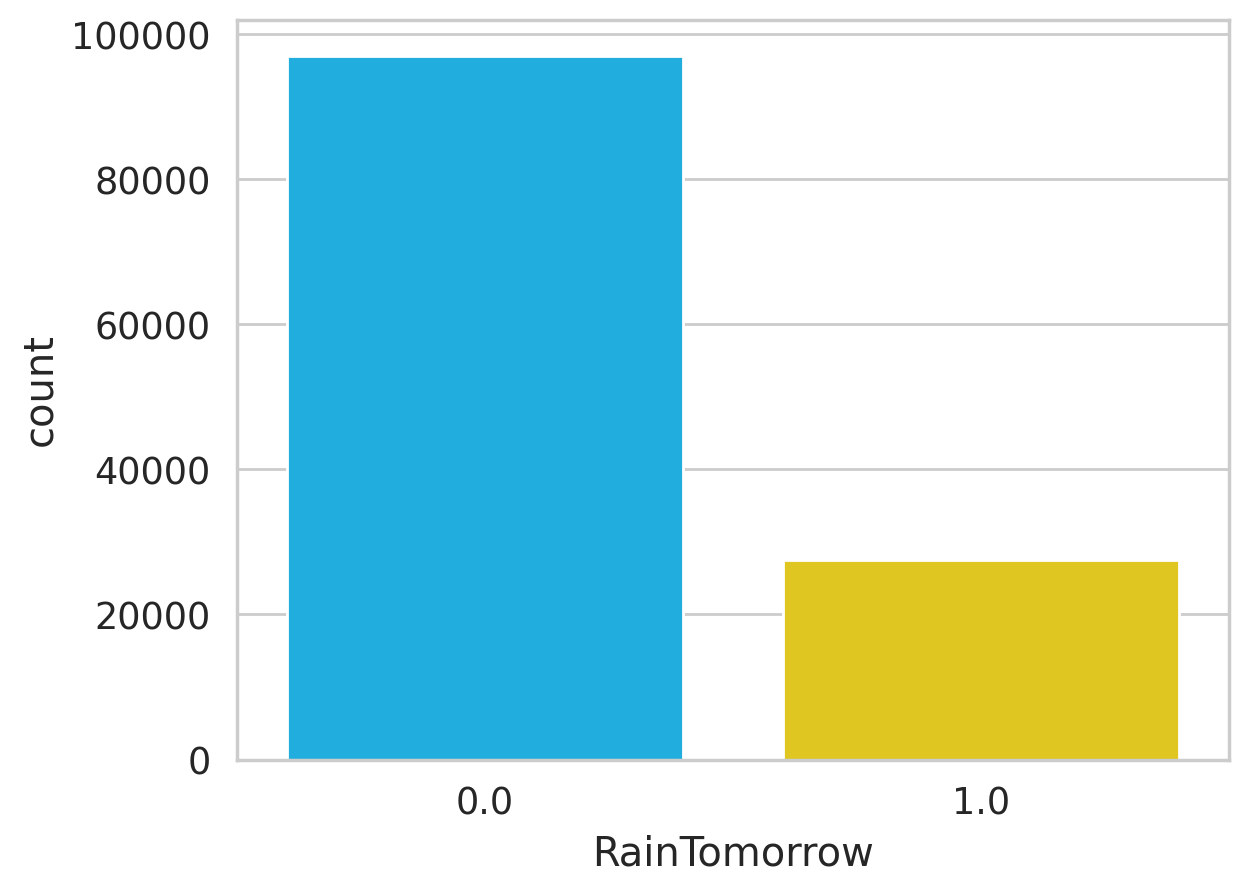

In [8]:
sns.countplot(df.RainTomorrow)

In [9]:
df.RainTomorrow.value_counts(normalize=True)

0.0    0.778762
1.0    0.221238
Name: RainTomorrow, dtype: float64

In [15]:
# will not handle umbalanced datasets
X = df[["Rainfall", "Humidity3pm", "RainToday", "Pressure9am"]]
y = df[["RainTomorrow"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [17]:
# passing to tensors
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([99751, 4]),
 torch.Size([24938, 4]),
 torch.Size([99751]),
 torch.Size([24938]))

In [23]:
# build a nn
class Net(nn.Module):
    def __init__(self, n_features) -> None:
        super(Net, self).__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(n_features, 5),
            nn.ReLU(),
            nn.Linear(5, 3),
            nn.ReLU(),
            nn.Linear(3, 1)
        )

    def forward(self, x):
        output = self.feed_forward(x)
        output_probs = torch.sigmoid(output)
        return output_probs

In [24]:
model = Net(X_train.shape[1])
model

Net(
  (feed_forward): Sequential(
    (0): Linear(in_features=4, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=1, bias=True)
  )
)